In [1]:
import lsst.daf.base as dafBase
import lsst.daf.persistence as dafPersist
import lsst.afw.table as afwTable
import lsst.afw.geom as afwGeom
import Utils.DiaSourceTools as DSTools


In [2]:
DATADIR="/renoir_data_02/jpreyes/lsst_data/CFHTLS_master/output/classTest"
butler = dafPersist.Butler(DATADIR)

In [3]:
clsds = butler.get("deepDiff_class_diaSrc", {'visit':836493, 'ccd':10, 'filter':'r'})

In [4]:
def multi_match_catalogs(catalog_list, data_refs):
    multi_matches = None

    for catalog, (visit, ccd) in zip(catalog_list, data_refs):

            if multi_matches is None and len(catalog)>0:
                multi_matches = afwTable.MultiMatch(catalog[0].schema, {'visit':int, 'ccd':int}, radius=afwGeom.Angle(1./3600., afwGeom.degrees))
            if multi_matches is not None:
                multi_matches.add(catalog, {'visit':int(visit), 'ccd':int(ccd)})

    results = multi_matches.finish(removeAmbiguous=False)  
    return results

In [5]:
data_refs = butler.queryMetadata("deepDiff_class_diaSrc", format=['visit', 'ccd'], dataId={'filter':'r'})
def_data_refs = []
catalogs = []
for data_ref in data_refs:
    if butler.datasetExists("deepDiff_class_diaSrc", dataId={'visit':data_ref[0], 'ccd':data_ref[1], 'filter':'r'}):
        catalog = butler.get("deepDiff_class_diaSrc", dataId={'visit':data_ref[0], 'ccd':data_ref[1], 'filter':'r'})
        catalogs.append(catalog)
        def_data_refs.append(data_ref)
        

    

In [6]:
results = multi_match_catalogs(catalogs, def_data_refs)

In [7]:
len(results)

831759

In [8]:
light_curves=DSTools.get_light_curves_from_multimatch_results2(results)
print len(light_curves)

287100


In [9]:

lcs = []
for light_curve in light_curves:
    lcs.append(DSTools.build_lightcurve2(light_curve, "base_CircularApertureFlux_4_5_flux"))

(31, 31)


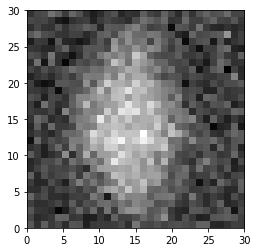

In [12]:
import numpy as np
import matplotlib.pyplot as plt
stamps = get_stamps_in_lc(lcs[10])
%matplotlib inline
stamp, c_stamp = stamps[2]

img_arr, mask_arr, var_arr = stamp.getMaskedImage().getArrays()
w,h = stamp.getWidth(), stamp.getHeight()  
plt.imshow(img_arr, origin='lower', vmin=img_arr.min(), vmax=img_arr.max(), cmap='gray', extent=(0,w-1, 0, h-1), interpolation='none')
print img_arr.shape

In [13]:
lcs[0]

mjd,classification,zpsys,flux,ra,flux_error,ccd,dec,zp,bandpass
int64,float64,str2,float64,object,float64,int64,object,float64,str5
836493,7.0,ab,2100896.25,3.76278 rad,1124.57751465,0,0.924503 rad,25.0,sdssr
836494,3.0,ab,1502626.75,3.76278 rad,1117.01904297,0,0.924503 rad,25.0,sdssr
836496,4.0,ab,1224021.0,3.76278 rad,1008.64624023,0,0.9245 rad,25.0,sdssr
836497,4.0,ab,394413.75,3.76278 rad,931.813842773,0,0.9245 rad,25.0,sdssr
836498,4.0,ab,554487.3125,3.76278 rad,1020.89581299,0,0.924504 rad,25.0,sdssr
837002,1.0,ab,44697.3359375,3.76277 rad,894.323913574,0,0.924501 rad,25.0,sdssr
837004,1.0,ab,149449.296875,3.76277 rad,933.845397949,0,0.924501 rad,25.0,sdssr
837006,1.0,ab,137629.375,3.76277 rad,956.864440918,18,0.924502 rad,25.0,sdssr
837007,1.0,ab,212028.75,3.76278 rad,953.796569824,18,0.924502 rad,25.0,sdssr


In [11]:
def get_stamps_in_lc(lc):
    ccds= range(0,36)
    stamps = []
    CenterRa = np.mean(lc["ra"])
    CenterDec = np.mean(lc["dec"])
    for point in lc:



        diffExp = butler.get("deepDiff_differenceExp", dataId={"filter":'r', 'visit':point["mjd"], 'ccd':point["ccd"]})
        box = diffExp.getBBox()
        wcs = diffExp.getWcs()
        coord = afwGeom.Point2I(wcs.skyToPixel(CenterRa, CenterDec))
        #calexp = butler.get("calexp", dataId={"filter":'r', 'visit':point["mjd"], 'ccd':ccd})
        calexp = butler.get("calexp", dataId={"filter":'r', 'visit':point["mjd"], 'ccd':point["ccd"]})



        Center = afwGeom.Point2I(wcs.skyToPixel(CenterRa, CenterDec))
        Begin = afwGeom.Point2I(Center.getX() - 15, Center.getY() - 15)
        End = afwGeom.Point2I(Center.getX() + 15, Center.getY() + 15)

        newBox = afwGeom.Box2I(Begin,End) 
        try:
            cal_stamp = calexp.Factory(calexp, newBox, True)
            stamp = diffExp.Factory(diffExp,newBox, True)
            stamps.append((stamp, cal_stamp))
        except Exception, e:
            print e
            stamps.append((None, None))
            pass
        
    return stamps

In [17]:
def generate_patches(butler, lc, lc_id):
    
    import numpy as np
    import lsst.daf.base as dafBase
    import lsst.daf.persistence as dafPersist
    import lsst.afw.table as afwTable
    import lsst.afw.geom as afwGeom
    import Utils.DiaSourceTools as DSTools
    path = "/renoir_data_02/jpreyes/stamp_data/filter_r/"
    CenterRa = np.mean(lc["ra"])
    CenterDec = np.mean(lc["dec"])
    for i, point in enumerate(lc):

       
        diffExp = butler.get("deepDiff_differenceExp", dataId={"filter":'r', 'visit':point["mjd"], 'ccd':point["ccd"]})
        box = diffExp.getBBox()
        wcs = diffExp.getWcs()
        coord = afwGeom.Point2I(wcs.skyToPixel(CenterRa, CenterDec))
        #calexp = butler.get("calexp", dataId={"filter":'r', 'visit':point["mjd"], 'ccd':ccd})
        calexp = butler.get("calexp", dataId={"filter":'r', 'visit':point["mjd"], 'ccd':point["ccd"]})


        Center = afwGeom.Point2I(wcs.skyToPixel(CenterRa, CenterDec))
        Begin = afwGeom.Point2I(Center.getX() - 16, Center.getY() - 16)
        End = afwGeom.Point2I(Center.getX() + 15, Center.getY() + 15)

        newBox = afwGeom.Box2I(Begin,End) 
        
        try:
            cal_stamp = calexp.Factory(calexp, newBox, True)
            stamp = diffExp.Factory(diffExp,newBox, True)            
            name = str(lc_id)+"-"+str(i)+"-"+str(point["mjd"])+"-"+str(int(point["classification"]))
            stamp.writeFits(path+name+".fits")
            
        except Exception, e:
            print e
            pass
        
        
        
    
    

In [14]:
import ipyparallel as ipyp

c = ipyp.Client()
v = c[:]
v = c.load_balanced_view()


res = v.map(lambda x,y: x+y, range(10), range(10))

print v
print res.get()

<LoadBalancedView None>
[0, 2, 4, 6, 8, 10, 12, 14, 16, 18]


In [18]:
test_lcs = lcs
size = len(test_lcs)
butlers = [butler]*size
lc_ids = range(size)
print len(test_lcs), len(butlers), len(lc_ids)

287100 287100 287100


In [19]:
res = v.map(generate_patches, butlers, lcs, lc_ids)

In [21]:
print res.get()

[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, Non

In [80]:
lc = lcs[0]
lc_id = 0
path = "/renoir_data_02/jpreyes/stamp_data/filter_r/"
CenterRa = np.mean(lc["ra"])
CenterDec = np.mean(lc["dec"])
for i, point in enumerate(lc):


    diffExp = butler.get("deepDiff_differenceExp", dataId={"filter":'r', 'visit':point["mjd"], 'ccd':point["ccd"]})
    box = diffExp.getBBox()
    wcs = diffExp.getWcs()
    coord = afwGeom.Point2I(wcs.skyToPixel(CenterRa, CenterDec))
    #calexp = butler.get("calexp", dataId={"filter":'r', 'visit':point["mjd"], 'ccd':ccd})
    calexp = butler.get("calexp", dataId={"filter":'r', 'visit':point["mjd"], 'ccd':point["ccd"]})


    Center = afwGeom.Point2I(wcs.skyToPixel(CenterRa, CenterDec))
    Begin = afwGeom.Point2I(Center.getX() - 16, Center.getY() - 16)
    End = afwGeom.Point2I(Center.getX() + 15, Center.getY() + 15)

    newBox = afwGeom.Box2I(Begin,End) 

    try:
        cal_stamp = calexp.Factory(calexp, newBox, True)
        stamp = diffExp.Factory(diffExp,newBox, True)            
        name = str(lc_id)+"-"+str(i)+"-"+str(point["mjd"])+"-"+str(int(point["classification"]))
        stamp.writeFits(path+name+".fits")

    except Exception, e:
        print e
        pass


In [82]:
import pickle
output = open('/renoir_data_02/jpreyes/stamp_data/lcs6sigma.pickle', 'wb')

# Pickle dictionary using protocol 0.
pickle.dump(lcs, output)
output.close()